In [8]:
#构建一个类线性模型类，继承自nn.Module,nn.m中封装了许多方法
#本模型所用的包含库
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset    #这是一个抽象类，无法实例化
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import os

#构建一个compose类的实例，包含转tensor（张量），后面那个是标准化，两个参数分别是均值和标准差
train_transform = transforms.Compose([
                                transforms.RandomAffine(degrees = 0,translate=(0.1, 0.1)),#对照片进行随机平移
                                transforms.RandomRotation((-180,180)),        #随机旋转
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))])

test_transform = transforms.Compose([transforms.RandomAffine(degrees = 0,translate=(0.1, 0.1)),#对照片进行随机平移
                                    transforms.ToTensor(),
                                    transforms.RandomRotation((-180,180)),        #随机旋转
                                    transforms.Normalize((0.1307,),(0.3081,))])

#这2个值也是调参重灾区……
train_batch_size = 256
learning_rate = 0.015
test_batch_size = 100
random_seed = 2         # 随机种子，设置后可以得到稳定的随机数
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) #为gpu提供随机数


train_dataset = datasets.MNIST(root='./mnist/', train=True, download=False, transform=train_transform)

test_dataset = datasets.MNIST(root='./mnist/', train=False, download=False, transform=test_transform)

train_loader = DataLoader(dataset=train_dataset,batch_size=train_batch_size,shuffle=True,pin_memory=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=test_batch_size,shuffle=False,pin_memory=True)

In [9]:
class ResidualBlock(nn.Module):
    # Residual Block需要保证输出和输入通道数x一样
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        # 3*3卷积核，保证图像大小不变将padding设为1
        # 第一个卷积
        self.conv1 = nn.Conv2d(channels, channels,
                               kernel_size=3, padding=1)
        # 第二个卷积
        self.conv2 = nn.Conv2d(channels, channels,
                               kernel_size=3, padding=1)
        #第三个卷积，1*1
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        # 激活
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        # 先求和 后激活
        z = self.conv3(x)
        return F.relu(z + y)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #卷积层
        self.conv1 = nn.Conv2d(1  ,32, kernel_size=5,padding=2)
        self.conv2 = nn.Conv2d(32 ,64, kernel_size=5,padding=2)
        self.conv3 = nn.Conv2d(64 ,128,kernel_size=5,padding=2)
        self.conv4 = nn.Conv2d(128,192,kernel_size=5,padding=2)

        #残差神经网络层，其中已经包含了relu
        self.rblock1 = ResidualBlock(32)
        self.rblock2 = ResidualBlock(64)
        self.rblock3 = ResidualBlock(128)
        self.rblock4 = ResidualBlock(192)
        
        #BN层，归一化，使数据在进行Relu之前不会因为数据过大而导致网络性能的不稳定
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(192)
        
        #最大池化，一般最大池化效果都比平均池化好些
        self.mp = nn.MaxPool2d(2)
        
        #fully connectected全连接层
        self.fc1 = nn.Linear(192*7*7, 256)  # 线性
        self.fc6 = nn.Linear(256, 10)  # 线性

    def forward(self, x):
        in_size = x.size(0)
        
        x = self.conv1(x)   #channels:1-32  w*h:28*28  
        x = self.bn1(x)
        x = F.relu(x) 
        x = self.rblock1(x)
        
        x = self.conv2(x)   #channels:32-64 w*h:28*28
        x = F.relu(x)   
        x = self.bn2(x)
        x = self.rblock2(x)
        
        x = self.mp(x)      #最大池化,channels:64-64    w*h:28*28->14*14
        

        x = self.conv3(x)   #channels:64-128    w*h:14*14
        x = self.bn3(x)
        x = F.relu(x)
        x = self.rblock3(x)

        x = self.conv4(x)   #channels:128-192   w*h:14*14
        x = self.bn4(x)
        x = F.relu(x)
        x = self.rblock4(x)
        
        x = self.mp(x)      #最大池化,channels:192-192  w*h:14*14->7*7

        x = x.view(in_size, -1)     #展开成向量
        x = F.relu(self.fc1(x))  # 使用relu函数来激活
        
        return self.fc6(x)

In [11]:
#调用GPU
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.backends.cudnn.benchmark = True       #启用cudnn底层算法
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)
torch.cuda.empty_cache()        #释放显存
model=Net()
model.load_state_dict(torch.load('params\\30-0.9745-net_params.pt'))
model.to(device)

# #构建损失函数
criterion = torch.nn.CrossEntropyLoss()      #交叉熵
#
# #构建优化器,参数1：模型权重，参数二，learning rate
optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=0.5)    #带动量0.5

#optimizer = optim.RMSprop(model.parameters(),lr=learning_rate,alpha=0.99,momentum = 0.5)
# optimizer = torch.optim.Adam(model.parameters(),
#                              lr=0.05,
#                              betas=(0.9, 0.999),
#                              eps=1e-08,
#                              weight_decay=0,
#                              amsgrad=False)
#设置学习率梯度下降，如果连续2个epoch测试准确率没有上升，则降低学习率，系数0.5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True, threshold=0.00005, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

In [12]:
#把训练封装成一个函数
def train(epoch):
    running_loss =0.0
    for batch_idx,data in enumerate(train_loader,0):
        inputs,target = data
        inputs,target = inputs.to(device),target.to(device)
        optimizer.zero_grad()

        #forward,backward,update
        outputs = model(inputs)
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        if batch_idx%300==299:
            train_loss_val.append((running_loss/300))
            #print('[%d,%5d] loss:%3f'%(epoch+1,batch_idx+1,running_loss/300))
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0

In [13]:
#把测试封装成函数
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            #torch.max()返回的是两个值，第一个是用_接受(蚌埠住了),第二个是pre
            _, predicted = torch.max(outputs.data,dim=1)       #从第一维度开始搜索
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
    print('Accuracy on test set: %f %% [%d/%d]' % (100 * correct / total, correct, total))

    return correct/total

Accuracy on test set: 97.570000 % [9757/10000]
1 0.9757
Accuracy on test set: 97.460000 % [9746/10000]
2 0.9746
Accuracy on test set: 97.590000 % [9759/10000]
3 0.9759
Accuracy on test set: 97.690000 % [9769/10000]
4 0.9769
Accuracy on test set: 97.430000 % [9743/10000]
5 0.9743
Accuracy on test set: 97.590000 % [9759/10000]
6 0.9759
Accuracy on test set: 97.510000 % [9751/10000]
7 0.9751
Epoch 00007: reducing learning rate of group 0 to 7.5000e-03.
Accuracy on test set: 97.520000 % [9752/10000]
8 0.9752
Accuracy on test set: 97.620000 % [9762/10000]
9 0.9762
Accuracy on test set: 97.490000 % [9749/10000]
10 0.9749
Epoch 00010: reducing learning rate of group 0 to 3.7500e-03.
Accuracy on test set: 97.620000 % [9762/10000]
11 0.9762
Accuracy on test set: 97.620000 % [9762/10000]
12 0.9762
Accuracy on test set: 97.680000 % [9768/10000]
13 0.9768
Epoch 00013: reducing learning rate of group 0 to 1.8750e-03.
Accuracy on test set: 97.680000 % [9768/10000]
14 0.9768
Accuracy on test set: 97.

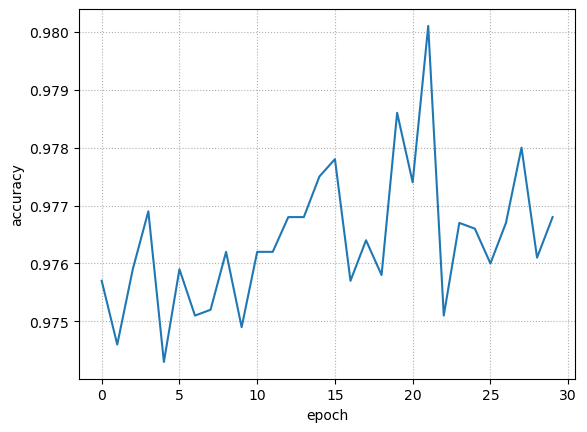

In [15]:
train_epoch = []
model_accuracy = []
temp_acc = 0.0
train_loss_val = []
for epoch in range(30):
    train(epoch)
    acc = test()

    print(epoch + 1,acc)
    train_epoch.append(epoch)
    model_accuracy.append(acc)
    scheduler.step(acc)
    torch.save(model.state_dict(), 'params\\'+str(epoch + 31)+'-'+str(acc)+'-'+'net_params.pt')   # 只保存网络中的参数 (速度快, 占内存少)

plt.figure(1)
plt.plot(train_epoch, model_accuracy)  # 传入列表，plt类用来画图
plt.grid(linestyle=':')
plt.ylabel('accuracy')  # 定义y坐标轴的名字
plt.xlabel('epoch')  # 定义x坐标
plt.show()  # 显示